In [47]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
map = gpd.read_file('../data/AgrImOnIa/raw/Comuni_correnti_poligonali.shp')
map = map.to_crs({'init': 'epsg:4326'})
map.head()

C:\Users\DVX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,OBJECTID,CLASSREF,BELFIORE,COD_ISTATN,NOME_COM,COD_PRO,NOME_PRO,SIG_PRO,COD_CMO,NOME_CMO,...,ANNO,ISTAT,LEGGE_ISTI,ATS_COD,ATS_DEC,CMETR_COD,CMETR_DEC,SHAPE_AREA,SHAPE_LEN,geometry
0,58,2ec835aa-55fd-4157-a4ef-9762bf1c4eac,A533,03016017,AZZONE,16,BERGAMO,BG,ZO09,VALLE DI SCALVE,...,1980,16017,None,030325,ATS DI BERGAMO,None,None,1.731573e+07,22193.780488,"POLYGON ((10.11432 45.93747, 10.11393 45.93752..."
1,63,93c3bba6-7115-4e4e-8426-a8752b94d9ee,I894,03018152,SPESSA,18,PAVIA,PV,None,None,...,1980,18152,None,030328,ATS DI PAVIA,None,None,1.236544e+07,16260.447426,"POLYGON ((9.36064 45.13149, 9.36010 45.12986, ..."
2,70,ade53e93-78e7-4990-b979-88de73da9ea1,D660,03098026,FOMBIO,98,LODI,LO,None,None,...,1980,98026,None,030321,ATS DELLA CITTA' METROPOLITANA DI MILANO,None,None,7.456725e+06,19279.664351,"POLYGON ((9.70211 45.14260, 9.70212 45.14259, ..."
3,71,d2fa448d-1769-4d7e-8189-1e78981391f3,G388,03018110,PAVIA,18,PAVIA,PV,None,None,...,2012,18110,None,030328,ATS DI PAVIA,None,None,6.323801e+07,47660.027322,"POLYGON ((9.20950 45.22094, 9.20963 45.22098, ..."
4,72,6c49be44-c6c3-497f-8dcb-2f4b5c8f9753,L788,03018175,VERRUA PO,18,PAVIA,PV,None,None,...,1980,18175,None,030328,ATS DI PAVIA,None,None,1.083022e+07,18259.383988,"POLYGON ((9.16910 45.13717, 9.17490 45.13226, ..."


In [9]:
model_file_name = "../output/Model_Gen2018_30wind_10m_0.csv"
model_data = gpd.read_file(model_file_name)
model_data.head()

,PM25_original,PM25_predictions,Altitude,WE_temp_2m,WE_tot_precipitation,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,WE_blh_layer_max,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,Municipality_Name,geometry
0,NA,-5.15230541902523,1292.89141657699,6.35739928498996,0.00515034198790413,9968858.59533596,63.1033809250364,81.4451558853514,93.8270689097739,923.121963891528,...,2.36832703071179,0.229586961258793,0.472625388946867,0.123371461739297,2.0746433047329,9.30622928944218,3.98429970246835,2.02856271270688,AZZONE,None
1,NA,2.26173160945549,64.306792678833,14.381378630137,0.0029441691169863,11235547.9452055,59.2392602739726,77.4788767123288,92.5795616438356,1008.10767123288,...,13.2430575342466,0.749470136986301,1.78636164383562,0.493997260273973,454.262191780822,17.2315616438356,1.32773424657534,1.76791232876712,SPESSA,None
2,NA,-2.91581483770549,55.7899148276466,14.438562323863,0.00308438741569909,11276985.2286297,60.8029264959852,78.3866853351498,93.2104351293615,992.118417985122,...,19.2528144888906,3.44275853431039,5.14354920031507,0.70468303980743,494.356077236112,93.4312297693483,2.05531089285105,1.99342142972486,FOMBIO,None
3,NA,-0.731491270501717,73.9744487857422,14.3949602502407,0.00309574161749634,11206963.8905858,57.9571631739989,76.6766744831466,92.2200848719314,1017.98465566845,...,9.57907450919444,2.36326704385574,4.7920845648723,0.796200989600352,48.7691334592991,23.1407995285116,0.844055900459224,1.50972298003664,PAVIA,None
4,NA,2.2127630636254,68.0622571107931,14.4093142524589,0.00292033600578723,11214484.3379074,57.9679052673138,76.545676441033,92.0900618727821,1011.97441949045,...,8.27346994978068,2.79920048947824,5.08896886638686,0.841093771634417,36.259135775273,13.1635447846146,1.36106977138499,1.5570352734408,VERRUA PO,None


In [29]:
geometry_cols = map[["NOME_COM", "geometry"]]
merged_df = pd.merge(model_data, geometry_cols, left_on="Municipality_Name", right_on="NOME_COM", how="inner")
merged_df.drop(["NOME_COM", "geometry_x"], axis=1, inplace=True)
merged_df.rename(columns={"geometry_y": "geometry"}, inplace=True)

# shift back the predictions by the initial value
mean_shift = pd.to_numeric(merged_df["PM25_original"], errors="coerce").mean()
merged_df["PM25_predictions"] = pd.to_numeric(merged_df["PM25_predictions"], errors="coerce") + mean_shift

merged_df.head()

,PM25_original,PM25_predictions,Altitude,WE_temp_2m,WE_tot_precipitation,WE_solar_radiation,WE_rh_min,WE_rh_mean,WE_rh_max,WE_blh_layer_max,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,Municipality_Name,geometry
0,NA,16.483545,1292.89141657699,6.35739928498996,0.00515034198790413,9968858.59533596,63.1033809250364,81.4451558853514,93.8270689097739,923.121963891528,...,2.36832703071179,0.229586961258793,0.472625388946867,0.123371461739297,2.0746433047329,9.30622928944218,3.98429970246835,2.02856271270688,AZZONE,"POLYGON ((10.11432 45.93747, 10.11393 45.93752..."
1,NA,23.897582,64.306792678833,14.381378630137,0.0029441691169863,11235547.9452055,59.2392602739726,77.4788767123288,92.5795616438356,1008.10767123288,...,13.2430575342466,0.749470136986301,1.78636164383562,0.493997260273973,454.262191780822,17.2315616438356,1.32773424657534,1.76791232876712,SPESSA,"POLYGON ((9.36064 45.13149, 9.36010 45.12986, ..."
2,NA,18.720035,55.7899148276466,14.438562323863,0.00308438741569909,11276985.2286297,60.8029264959852,78.3866853351498,93.2104351293615,992.118417985122,...,19.2528144888906,3.44275853431039,5.14354920031507,0.70468303980743,494.356077236112,93.4312297693483,2.05531089285105,1.99342142972486,FOMBIO,"POLYGON ((9.70211 45.14260, 9.70212 45.14259, ..."
3,NA,20.904359,73.9744487857422,14.3949602502407,0.00309574161749634,11206963.8905858,57.9571631739989,76.6766744831466,92.2200848719314,1017.98465566845,...,9.57907450919444,2.36326704385574,4.7920845648723,0.796200989600352,48.7691334592991,23.1407995285116,0.844055900459224,1.50972298003664,PAVIA,"POLYGON ((9.20950 45.22094, 9.20963 45.22098, ..."
4,NA,23.848613,68.0622571107931,14.4093142524589,0.00292033600578723,11214484.3379074,57.9679052673138,76.545676441033,92.0900618727821,1011.97441949045,...,8.27346994978068,2.79920048947824,5.08896886638686,0.841093771634417,36.259135775273,13.1635447846146,1.36106977138499,1.5570352734408,VERRUA PO,"POLYGON ((9.16910 45.13717, 9.17490 45.13226, ..."


C:\Users\DVX\AppData\Local\Temp\ipykernel_17684\4009849705.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df["PM25_original"].replace("NA", 0, inplace=True)


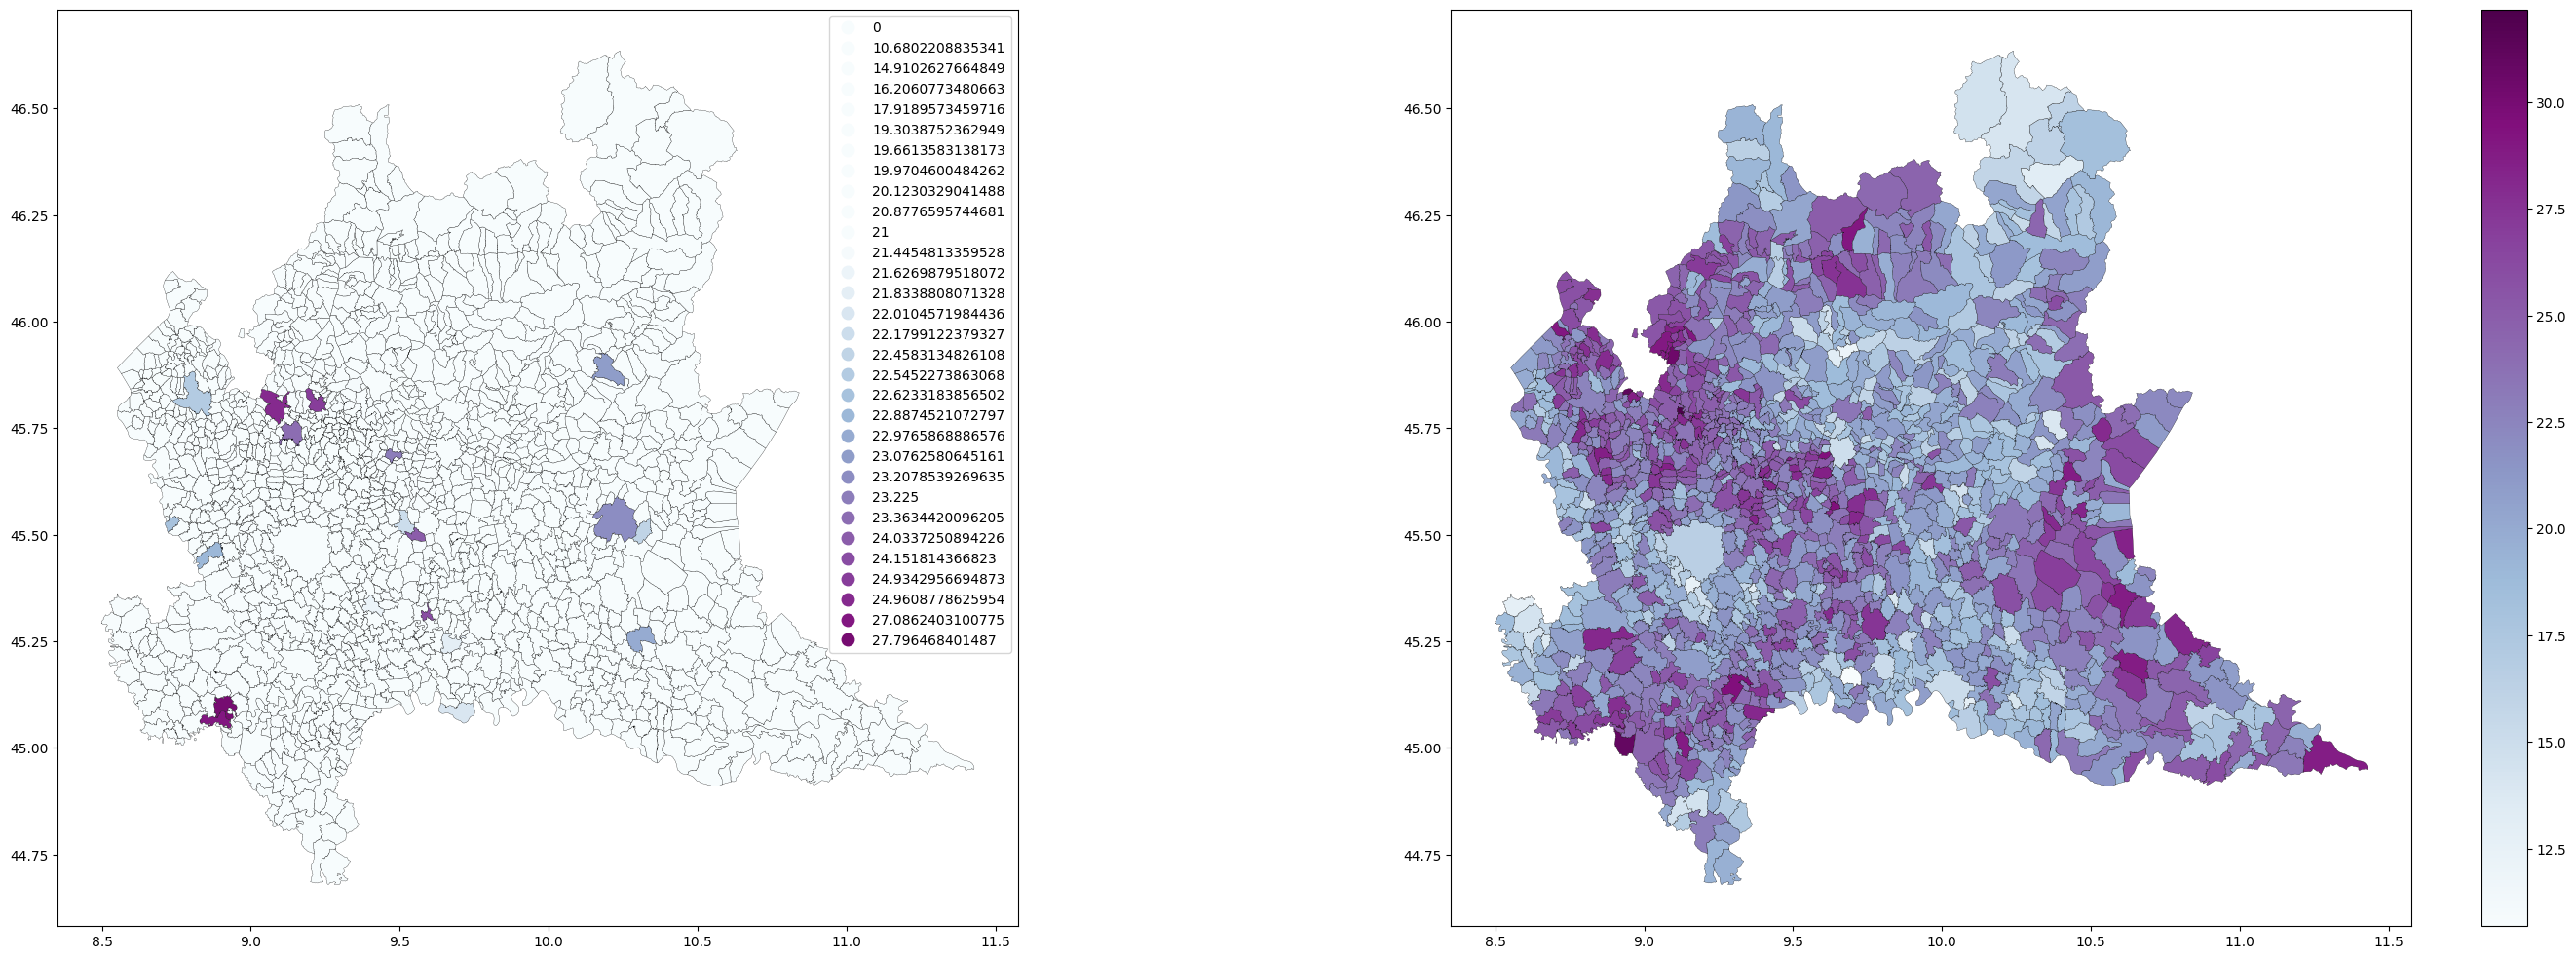

In [83]:
merged_df = merged_df.to_crs(map.crs)
cleaned_df = merged_df
cleaned_df["PM25_original"].replace("NA", 0, inplace=True)
# merged_df.plot(column="PM25_predictions", legend=True, cmap="BuPu")

min_value = min(merged_df["PM25_predictions"])
max_value = max(merged_df["PM25_predictions"])

fig, axs = plt.subplots(1, 2, figsize=(30, 10))

plt.tight_layout()
plot_values = ["PM25_original", "PM25_predictions"]
for i, ax in enumerate(axs): 
    cleaned_df.plot(
        ax=ax, 
        column=plot_values[i], 
        legend=True, 
        cmap="BuPu", 
        edgecolor='black', 
        linewidth=0.2,
        vmin=min_value,
        vmax=max_value
    )

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'EM_nh3_livestock_mm'),
  Text(1, 0, 'WE_rh_mean'),
  Text(2, 0, 'WE_rh_max'),
  Text(3, 0, 'LA_hvi'),
  Text(4, 0, 'EM_so2_sum'),
  Text(5, 0, 'WE_solar_radiation'),
  Text(6, 0, 'EM_nox_sum'),
  Text(7, 0, 'WE_blh_layer_min'),
  Text(8, 0, 'EM_nh3_agr_soils'),
  Text(9, 0, 'Municipality_Name'),
  Text(10, 0, 'WE_blh_layer_max'),
  Text(11, 0, 'LI_pigs'),
  Text(12, 0, 'EM_nh3_sum'),
  Text(13, 0, 'WE_temp_2m'),
  Text(14, 0, 'LI_bovine'),
  Text(15, 0, 'Altitude'),
  Text(16, 0, 'WE_rh_min'),
  Text(17, 0, 'LA_lvi'),
  Text(18, 0, 'EM_nh3_agr_waste_burn'),
  Text(19, 0, 'EM_nox_traffic'),
  Text(20, 0, 'WE_tot_precipitation')])

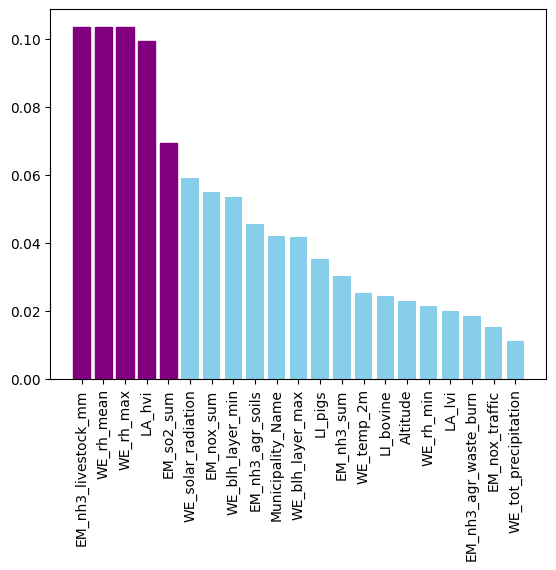

In [67]:
covariates_sel_file_name = "../output/2019_04_to_12_model_30wind_10m_0_cov_inclusion.csv"
covariates_selection = pd.read_csv(covariates_sel_file_name)

burnin = 1000
covariates_selection = covariates_selection.iloc[burnin:]
inclusion_probabilities = covariates_selection.sum(axis=0)
inclusion_probabilities = inclusion_probabilities / sum(inclusion_probabilities)

inclusion_probabilities = pd.DataFrame(inclusion_probabilities.sort_values(ascending=False))
inclusion_probabilities.columns = ["Inclusion_probability"]

bars = plt.bar(inclusion_probabilities.index, inclusion_probabilities["Inclusion_probability"], color="skyblue")

# highlight highest inclusion probabilities
for i, bar in enumerate(bars):
    if i < 5: 
        bar.set_color('purple')
        
plt.xticks(rotation=90)